<a href="https://colab.research.google.com/github/alirezakhaleghianaghizi/Deep-generative-models/blob/main/DGM_HW3_GAN_Practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 3: Generative Adversarial Networks
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [2]:
name = 'alireza khaleghi anaghizi'
std_id = '99101462'

### In this notebook, you will implement the required components from scratch, without code completion. Utilize `torch` to create models and perform optimization. The goal of this assignment is to implement Deep Convolutional Generative Adversarial Networks (DC-GAN) using the MNIST dataset and to explore interpolation in the latent space.

### To get started, please read the DC-GAN paper available at this link: [DC-GAN Paper](https://arxiv.org/abs/1511.06434v2).


### Part 1. Load the MNIST dataset.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define transformations for MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create DataLoader
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check dataset loading
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:10<00:00, 909kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.82MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Train Dataset Size: 60000
Test Dataset Size: 10000


### Part 2: Build the Generator and Discriminator models.
Build the models with the architecture guidelines for stable training as described in the paper. It is recommended to use the model parameters presented in `config.yaml`, but you are free to choose any set of parameters you prefer.


In [3]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # Output: 128 x 7 x 7

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # Output: 64 x 14 x 14

            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # Map output to [-1, 1]
            # Output: img_channels x 28 x 28
        )

    def forward(self, z):
        return self.model(z)
class Discriminator(nn.Module):
    def __init__(self, img_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input: img_channels x 28 x 28
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 64 x 14 x 14

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 128 x 7 x 7

            nn.Conv2d(128, 1, kernel_size=7, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # Output: 1
        )

    def forward(self, img):
        return self.model(img).view(-1, 1).squeeze(1)


### Part 3: Write a function to train the models using the GAN framework.
You can refer to the slides or the original GAN paper for the training schema: [GAN Paper](https://arxiv.org/abs/1406.2661). Additionally, create a function to generate samples from the model. Ensure to plot a grid of generated samples every n'th epoch.


In [4]:
import torch.optim as optim

# Hyperparameters
latent_dim = 100
img_channels = 1
lr = 0.0002
beta1 = 0.5
epochs = 50

# Initialize models, optimizer, and loss
generator = Generator(latent_dim, img_channels).cuda()
discriminator = Discriminator(img_channels).cuda()
criterion = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Training loop
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_loader):
        real_imgs = imgs.cuda()
        batch_size = real_imgs.size(0)

        # Generate labels
        real_labels = torch.ones(batch_size).cuda()
        fake_labels = torch.zeros(batch_size).cuda()

        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Real images
        outputs = discriminator(real_imgs)
        d_loss_real = criterion(outputs, real_labels)

        # Fake images
        z = torch.randn(batch_size, latent_dim, 1, 1).cuda()
        fake_imgs = generator(z)
        outputs = discriminator(fake_imgs.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        # Total loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        # Train Generator
        # -----------------
        optimizer_G.zero_grad()

        z = torch.randn(batch_size, latent_dim, 1, 1).cuda()
        fake_imgs = generator(z)
        outputs = discriminator(fake_imgs)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}]  Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}")


Epoch [1/50]  Loss D: 0.7942, Loss G: 1.8909
Epoch [2/50]  Loss D: 0.4868, Loss G: 1.6845
Epoch [3/50]  Loss D: 0.4719, Loss G: 1.7476
Epoch [4/50]  Loss D: 0.7712, Loss G: 3.1104
Epoch [5/50]  Loss D: 0.5316, Loss G: 2.0540
Epoch [6/50]  Loss D: 0.7319, Loss G: 1.4059
Epoch [7/50]  Loss D: 0.6134, Loss G: 1.6020
Epoch [8/50]  Loss D: 0.4766, Loss G: 2.1396
Epoch [9/50]  Loss D: 0.4601, Loss G: 1.7115
Epoch [10/50]  Loss D: 0.6293, Loss G: 1.7161
Epoch [11/50]  Loss D: 0.5436, Loss G: 2.0180
Epoch [12/50]  Loss D: 0.4551, Loss G: 1.6557
Epoch [13/50]  Loss D: 0.7240, Loss G: 2.6064
Epoch [14/50]  Loss D: 0.6969, Loss G: 1.3960
Epoch [15/50]  Loss D: 0.7912, Loss G: 2.3256
Epoch [16/50]  Loss D: 0.5935, Loss G: 2.2395
Epoch [17/50]  Loss D: 0.6027, Loss G: 2.8456
Epoch [18/50]  Loss D: 0.5654, Loss G: 3.0478
Epoch [19/50]  Loss D: 0.4971, Loss G: 2.3787
Epoch [20/50]  Loss D: 0.6423, Loss G: 0.9131
Epoch [21/50]  Loss D: 0.5519, Loss G: 2.7102
Epoch [22/50]  Loss D: 0.5607, Loss G: 1.77

### Part 4: Plot a grid of 100 generated samples.

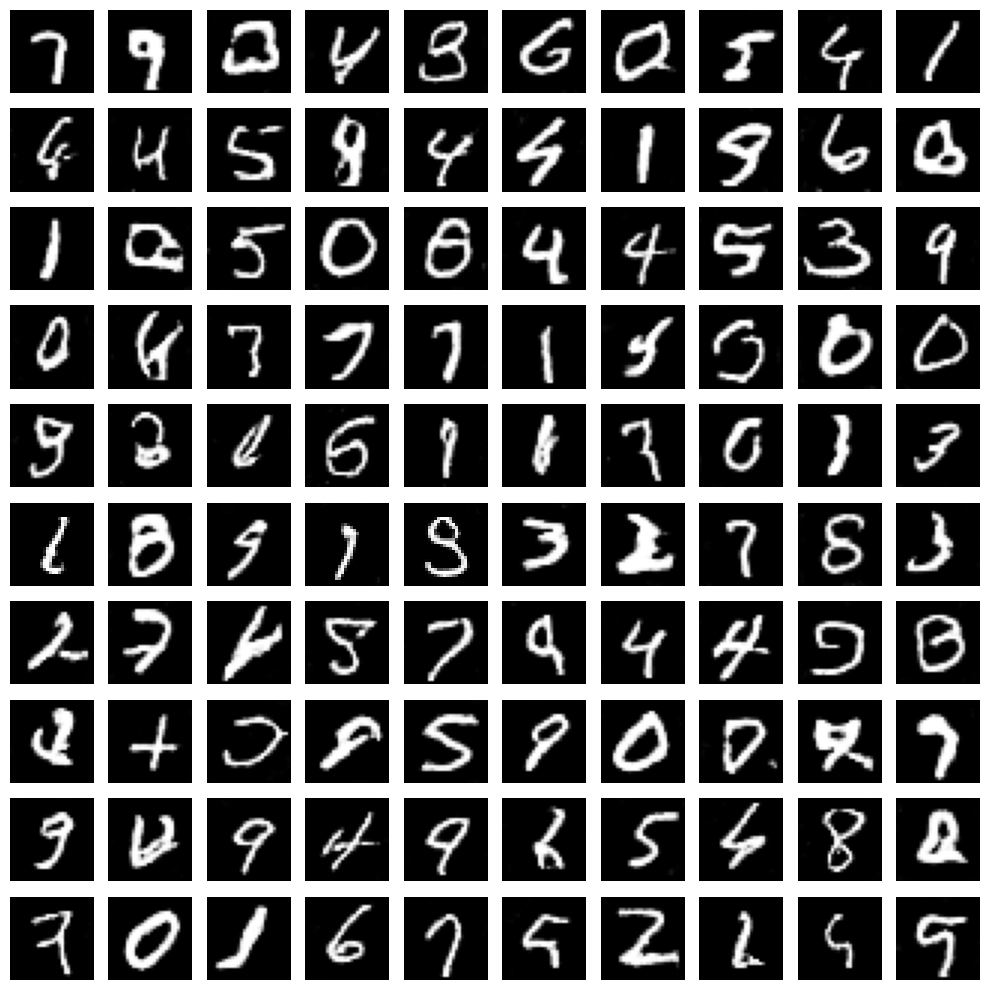

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_generated_samples(generator, latent_dim, num_samples=100):
    generator.eval()
    z = torch.randn(num_samples, latent_dim, 1, 1).cuda()
    with torch.no_grad():
        generated_imgs = generator(z).cpu()

    # Rescale images to [0, 1]
    generated_imgs = (generated_imgs + 1) / 2

    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(10):
        for j in range(10):
            axes[i, j].imshow(generated_imgs[i * 10 + j][0], cmap="gray")
            axes[i, j].axis("off")
    plt.tight_layout()
    plt.show()

plot_generated_samples(generator, latent_dim)


### Part 5: GAN Inversion
In this part, we aim to find the latent vectors corresponding to the samples in the dataset. First, select a random sample from the real dataset and a random latent vector. Freeze the generator and feed the random latent vector into the Generator. Next, define an MSE or MAE loss between the generated sample and the real sample, and optimize the random latent vector to discover the latent vector that generates the selected real sample.


In [6]:
def gan_inversion(generator, target_img, latent_dim, steps=500, lr=0.01):
    target_img = target_img.cuda().unsqueeze(0)
    z = torch.randn(1, latent_dim, 1, 1, requires_grad=True, device='cuda')
    optimizer = optim.Adam([z], lr=lr)

    criterion = nn.MSELoss()
    for step in range(steps):
        optimizer.zero_grad()
        generated_img = generator(z)
        loss = criterion(generated_img, target_img)
        loss.backward()
        optimizer.step()

    return z.detach()

# Example usage with a real sample
target_img, _ = train_dataset[0]
latent_vector = gan_inversion(generator, target_img, latent_dim)


### Part 6: Interpolating the Latent Space
In this part, you will interpolate the latent space using a 10 by 10 grid. Start with 4 initial points representing the corners of the square, and then perform linear or spherical interpolation between the latent vectors of these 4 images to fill the circumference of the square.
Next, fill in the rest of the square by interpolating between the latent vectors along the circumference.

If $G$ is the generator, and $z_1$ and $z_2$ are two latent vectors of two images, let $w$ be a parameter that varies between $0$ and $1$. The linearly interpolated sample is generated as:

\begin{equation}
G(w \cdot z_1 + (1 - w) \cdot z_2)\
\end{equation}

Try to select the 4 starting images from those that exhibit distinct features. For example, the two top right corners could be the same digit but one with a thick stroke and the other with a thin stroke, while the other two points should be from a different digit but with varying stroke styles.

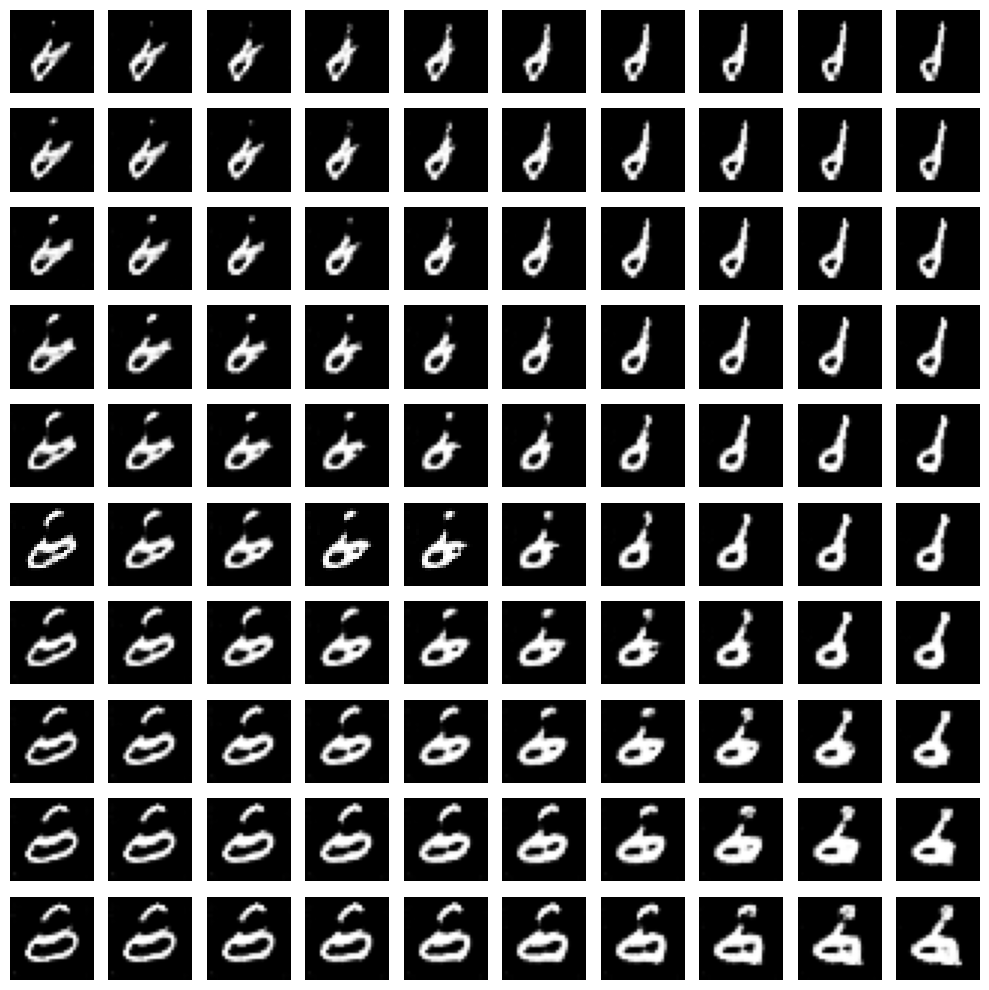

In [7]:
def interpolate_latent_space(generator, latent_dim, points=10):
    corners = torch.randn(4, latent_dim, 1, 1).cuda()
    interpolated_imgs = []

    for i in range(points):
        for j in range(points):
            w1, w2 = i / (points - 1), j / (points - 1)
            z = (w1 * corners[0] + (1 - w1) * corners[1] +
                 w2 * corners[2] + (1 - w2) * corners[3])
            with torch.no_grad():
                img = generator(z.unsqueeze(0)).cpu()
            interpolated_imgs.append((img + 1) / 2)

    fig, axes = plt.subplots(points, points, figsize=(10, 10))
    for i in range(points):
        for j in range(points):
            axes[i, j].imshow(interpolated_imgs[i * points + j][0][0], cmap="gray")
            axes[i, j].axis("off")
    plt.tight_layout()
    plt.show()

interpolate_latent_space(generator, latent_dim)


### Part 7: Arithmetic Operation in Latent Space
In this part, you will attempt to modify the thickness or thinness of a sample by identifying the direction in the latent space that corresponds to these attributes. Additionally, you can explore changing a digit to another (e.g., transforming a digit into a 3) by finding the direction in the latent space that corresponds to that digit.


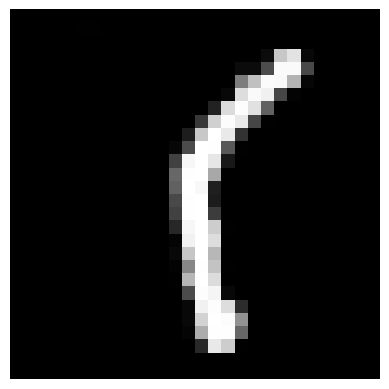

In [9]:
def modify_latent_space(generator, latent_vector, direction, alpha=1.0):
    # Ensure latent_vector and direction have the correct shape
    if len(latent_vector.shape) != 4:
        latent_vector = latent_vector.view(1, -1, 1, 1)  # Reshape to [batch_size, latent_dim, 1, 1]
    if len(direction.shape) != 4:
        direction = direction.view(1, -1, 1, 1)  # Reshape to [batch_size, latent_dim, 1, 1]

    # Modify the latent vector
    modified_vector = latent_vector + alpha * direction
    with torch.no_grad():
        modified_img = generator(modified_vector).cpu()

    # Plot the modified image
    plt.imshow((modified_img[0][0] + 1) / 2, cmap="gray")
    plt.axis("off")
    plt.show()

# Example: Generate a random direction and apply the modification
latent_vector = latent_vector.view(1, latent_dim, 1, 1)  # Ensure correct shape
direction = torch.randn_like(latent_vector)
modify_latent_space(generator, latent_vector, direction)


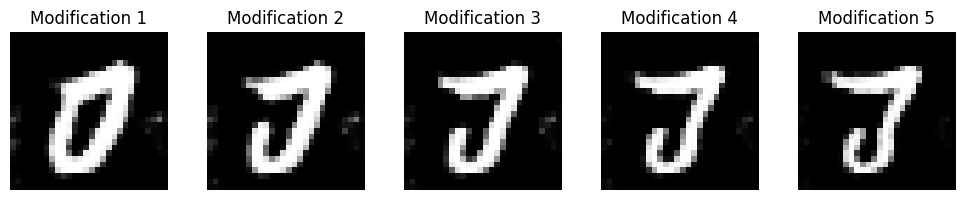

In [10]:
import matplotlib.pyplot as plt
import torch

def modify_latent_space(generator, latent_vector, direction, alpha=1.0, num_examples=5):
    # Ensure latent_vector and direction have the correct shape
    if len(latent_vector.shape) != 4:
        latent_vector = latent_vector.view(1, -1, 1, 1)  # Reshape to [batch_size, latent_dim, 1, 1]
    if len(direction.shape) != 4:
        direction = direction.view(1, -1, 1, 1)  # Reshape to [batch_size, latent_dim, 1, 1]

    # Create a figure to display multiple images
    fig, axes = plt.subplots(1, num_examples, figsize=(num_examples * 2, 2))

    for i in range(num_examples):
        # Modify the latent vector by scaling the direction by alpha
        modified_vector = latent_vector + alpha * direction * (i + 1)  # Apply different levels of modification
        with torch.no_grad():
            modified_img = generator(modified_vector).cpu()

        # Plot the modified image
        axes[i].imshow((modified_img[0][0] + 1) / 2, cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(f"Modification {i+1}")

    plt.tight_layout()
    plt.show()

# Example: Generate a random latent vector and direction, then modify it
latent_vector = torch.randn(1, latent_dim, 1, 1).cuda()  # Random initial latent vector
direction = torch.randn_like(latent_vector).cuda()  # Random direction for modification

modify_latent_space(generator, latent_vector, direction, alpha=0.1, num_examples=5)
